# Heterogeneous Velocity Model

In [24]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import Diffrapy as df

In [25]:
importlib.reload(df)

<module 'Diffrapy' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\Diffrapy.py'>

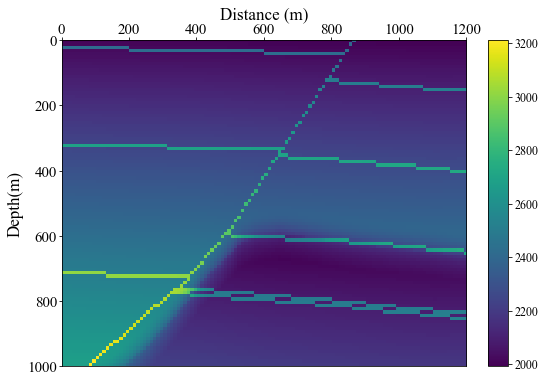

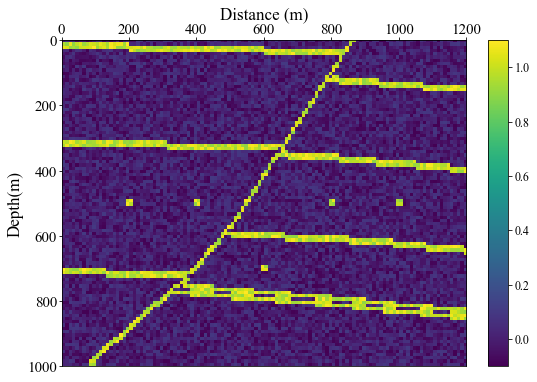

In [4]:
fr=40
nps=200
dt=.005 
rick=df.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=120
ntr=120
nz=100
dt=.005
dx=10  #meters
dz=10  #meters
c=1992 #velocidade m/s

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

velvector1 = np.loadtxt("Data/velvector") # Modelo de velocidade - 1 coluna em ASCII
vel = np.reshape(velvector1,[201,501]) # Coloca na dimensão correta
vel1 = vel[40:140,240:360] # Recorta um pequeno pedaço do modelovel[40:140,250:360]

c=vel1.min()
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
SW = 1./vel1 # Modelo de vagarosidade

df.plot(vel1,"velocity_model",nx,dx,nz,dz,"Distance (m)","Depth(m)")

dvel1=(np.abs(np.diff(vel1,axis=0)));
mx=np.max(dvel1.flatten('F'));  # Compute Refl Model for vel1;
dvel1=dvel1/mx;
dvel1=np.round(dvel1);
dvv=dvel1[nz-2,:]
R=np.append(dvel1,dvv[np.newaxis],axis=0);   # We lost a row in R by diff() so we add it back again

#Adding diff points
R[50-1:50+1,20-1:20+1] = 1 
R[50-1:50+1,40-1:40+1] = 1 
R[50-1:50+1,80-1:80+1] = 1 
R[50-1:50+1,100-1:100+1] = 1 
R[70-1:70+1,60-1:60+1] = 1 

#Adicionando ruído no modelo
nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.2

df.plot(R,"reflectivity_model",nx,dx,nz,dz,"Distance (m)","Depth(m)")

In [5]:
#TT = df.raymodel3(SW,dx,ntr,"Data/CSG/raiosVelvector2.npy")

In [6]:
with open("Data/CSG/raiosVelvector2.npy", 'rb') as f:
    TTh = np.load(f)
    
timer=np.round(TTh/dt)+1

In [7]:
#Creating the synthetic csg

dsx = 5 #talvez dê bug na hora de abrir os files usando esse dsx != 1, preciso testar isso!!!
nsx = nx
ngx = nx

#files = df.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,"Data/CSG/Diff_velvector2")

In [8]:
files = []

for i in range(0,nsx,dsx):
    filename = "Data/CSG/Diff_velvector2_{}".format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [9]:
pmin = -2
pmax = 2
dp = 0.1
xwin=zwin = 30
x_ini=z_ini = 0

#pm,sm = df.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp) 
#
#with open("Data/CSG/Diff_velvector2_dipfield", "wb") as f: 
#    np.save(f, pm)
#    
#with open("Data/CSG/Diff_velvector2_semblance", "wb") as f: 
#    np.save(f, sm)

with open("Data/CSG/Diff_velvector2_dipfield", "rb") as f:
    pm = np.load(f)

with open("Data/CSG/Diff_velvector2_semblance", "rb") as f:
    sm = np.load(f)

In [10]:
m_theta = np.arctan(pm)

X = np.sin(m_theta)
Y = np.cos(m_theta)

In [11]:
importlib.reload(df)

<module 'Diffrapy' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\Diffrapy.py'>

In [12]:
shot = 60

file_original = 'Data/CSG/Diff_velvector2_{}'.format(int(shot))

with open(file_original, 'rb') as file:
    gather1t = np.load(file)

gather1=gather1t[0:nt,:]
isx=shot

In [13]:
dwin=dt
win=10*dt #(metade) janela em tempo em cada etapa
app_ref=20 # abertura reflexões
app_dif=50 # abertura difrações

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.51it/s]


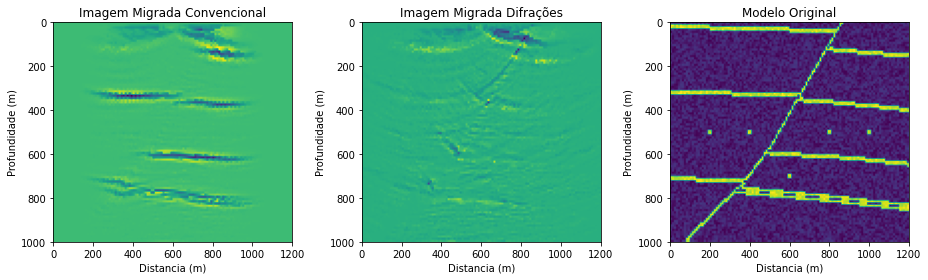

In [28]:
dwin=dt
win=10*dt #(metade) janela em tempo em cada etapa
app_ref=20 # abertura reflexões
app_dif=50 # abertura difrações

refl,diff = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

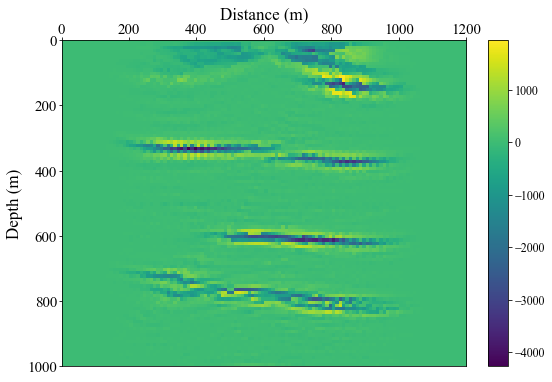

In [29]:
df.plot(refl,"mig1_refl",nx,dx,nz,dz,"Distance (m)","Depth (m)")

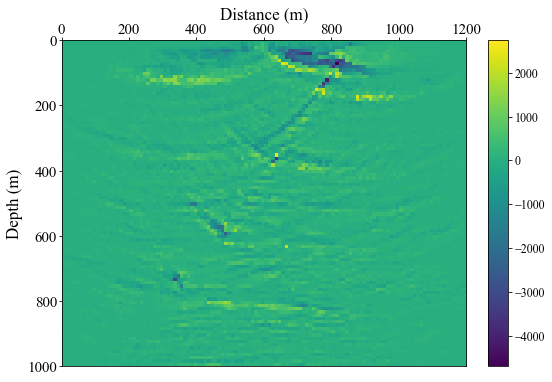

In [30]:
df.plot(diff,"mig1_diff",nx,dx,nz,dz,"Distance (m)","Depth (m)")

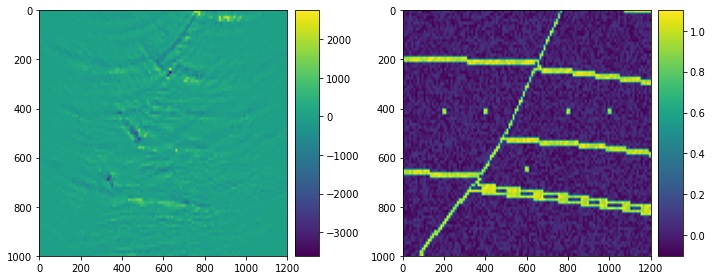

In [15]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [18]:
with open("Data/vv_mig_refl", "wb") as f: 
    np.save(f, refl_stackteste)
    
with open("Data/vv_mig_diff", "wb") as f: 
    np.save(f, diff_stackteste)

24it [03:34,  8.95s/it]


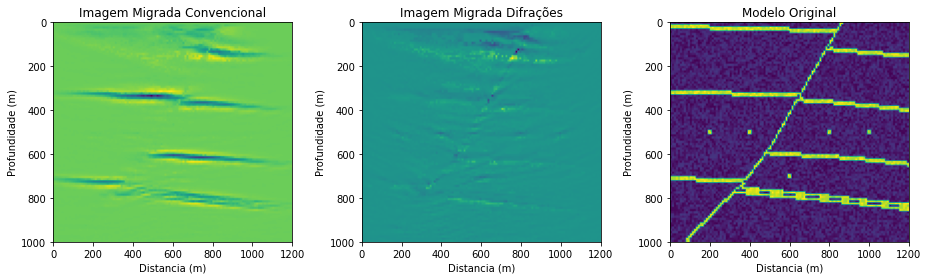

In [16]:
refl_stackteste,diff_stackteste = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

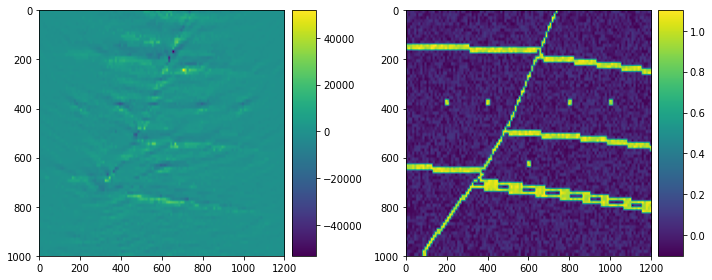

In [17]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff_stackteste[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])#,interpolation="nearest")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
refl_stackteste,diff_stackteste = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

**********

# Testando Modelos de Velocidade Errôneos

**********

In [23]:
vel1_toohigh = vel1*1.05
vel1_toolow = vel1*0.95
SW_toohigh = 1./vel1_toohigh
SW_toolow = 1./vel1_toolow

In [26]:
#TT = df.raymodel3(SW,dx,ntr,"Data/CSG/raiosVelvector2.npy")

In [27]:
TT_toohigh = df.raymodel3(SW_toohigh,dx,ntr,"Data/CSG/raiosVelvector2_toohigh.npy")

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [11:38<00:00,  5.82s/it]


In [28]:
TT_toolow = df.raymodel3(SW_toolow,dx,ntr,"Data/CSG/raiosVelvector2_toolow.npy")

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [11:39<00:00,  5.83s/it]


In [29]:
with open("Data/CSG/raiosVelvector2.npy", 'rb') as f:
    TTh = np.load(f)
    
with open("Data/CSG/raiosVelvector2_toohigh.npy", 'rb') as f:
    TTh_toohigh = np.load(f)
    
with open("Data/CSG/raiosVelvector2_toolow.npy", 'rb') as f:
    TTh_toolow = np.load(f)

timer=np.round(TTh/dt)+1
timer_toohigh=np.round(TTh_toohigh/dt)+1
timer_toolow=np.round(TTh_toolow/dt)+1

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:09<00:00, 12.50it/s]


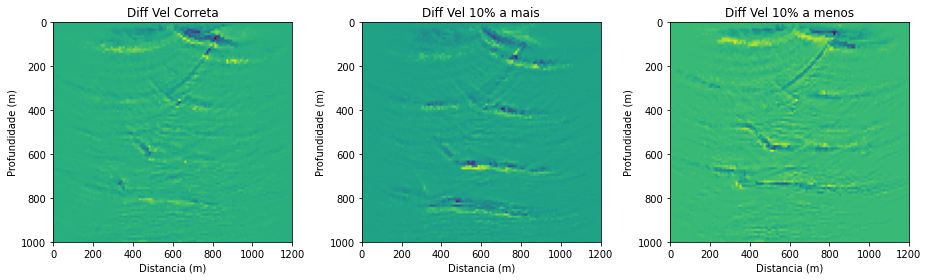

In [30]:
refl,diff = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm,SW)
refl_toohigh,diff_toohigh = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toohigh,X,Y,sm,SW)
refl_toolow,diff_toolow = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toolow,X,Y,sm,SW)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diff Vel 10% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Diff Vel 10% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

24it [03:59,  9.97s/it]
24it [03:52,  9.69s/it]
24it [03:39,  9.13s/it]


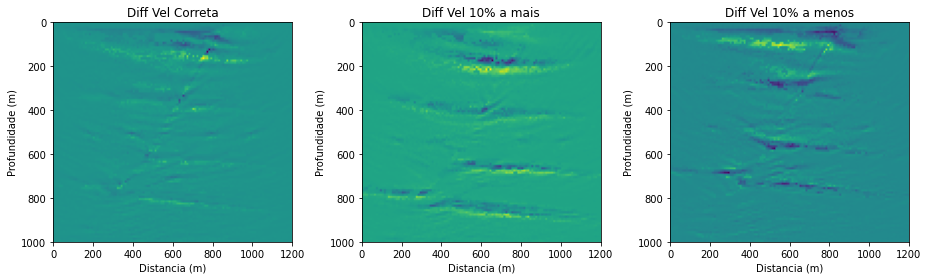

In [32]:
refl,diff = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm,SW)
refl_toohigh,diff_toohigh = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toohigh,X,Y,sm,SW)
refl_toolow,diff_toolow = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toolow,X,Y,sm,SW)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diff Vel 10% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Diff Vel 10% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

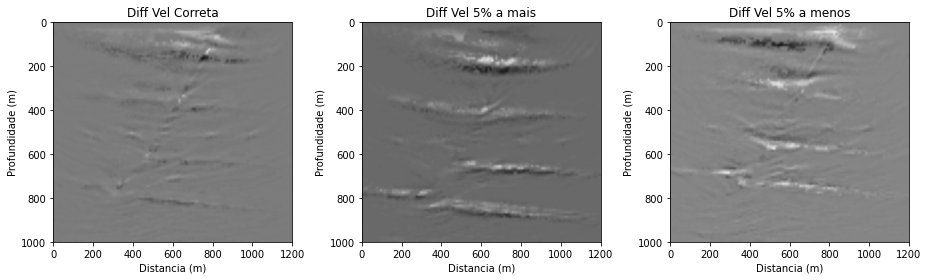

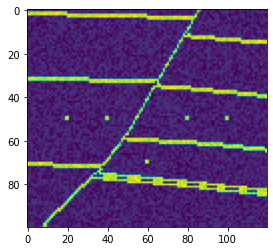

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

cm="binary"
it="gaussian"

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax2.set_title("Diff Vel 5% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax3.set_title("Diff Vel 5% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(4.3,4))
plt.imshow(R,aspect="auto")
plt.show()